# Pricing Optimization Project


In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

In [20]:
# Load dataset
df = pd.read_csv('retail_price.csv')
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [21]:
# Convert date column
df['month_year'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y', errors='coerce')
# Drop missing critical values
df = df.dropna(subset=['unit_price','qty'])
# Feature engineering
df['gap_comp1'] = df['unit_price'] - df['comp_1']
df['gap_comp2'] = df['unit_price'] - df['comp_2']
df['gap_comp3'] = df['unit_price'] - df['comp_3']
df['month'] = df['month_year'].dt.month
df['year'] = df['month_year'].dt.year
# Add seasonality features
df['month'] = df['month_year'].dt.month
df['year'] = df['month_year'].dt.year
 
# Save cleaned dataset
df.to_csv('retail_price_cleaned.csv', index=False)
print("Cleaned dataset saved as retail_price_cleaned.csv with shape:", df.shape)

Cleaned dataset saved as retail_price_cleaned.csv with shape: (676, 33)


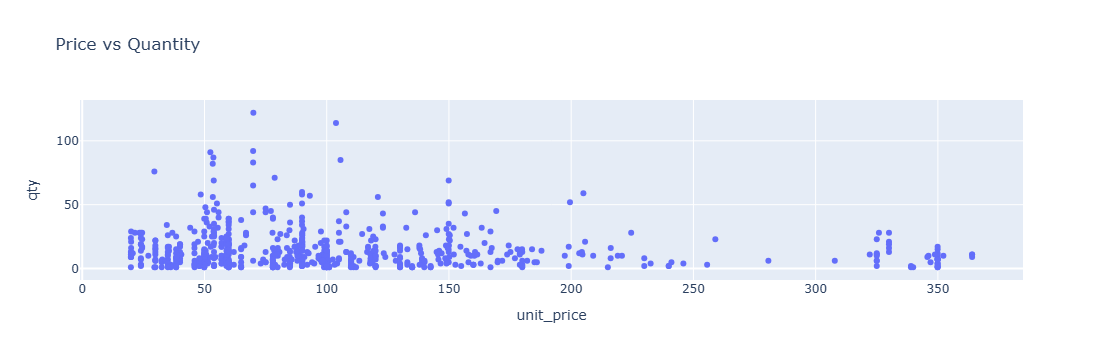

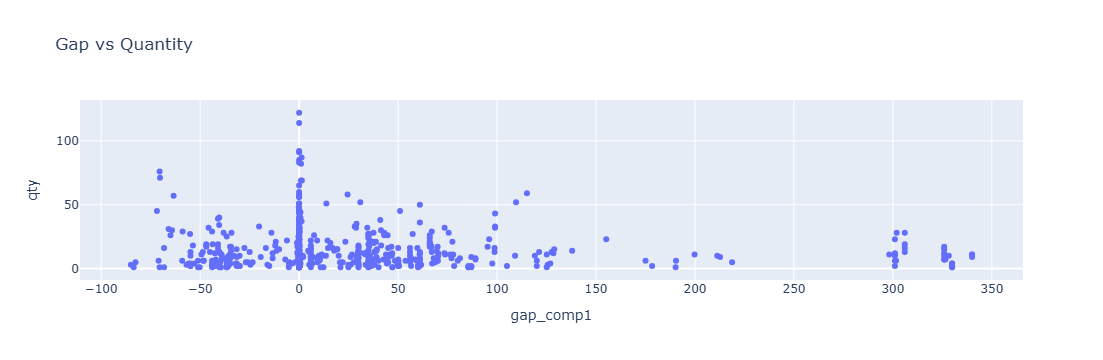

In [22]:
# Price vs Quantity
fig1 = px.scatter(df, x='unit_price', y='qty', title='Price vs Quantity')
fig1.show()
# Competitor influence
fig2 = px.scatter(df, x='gap_comp1', y='qty', title='Gap vs Quantity')
fig2.show()

In [23]:
feature_cols = ['unit_price','gap_comp1','gap_comp2','gap_comp3','month']
X = df[feature_cols]
y = df['qty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
lin_model = LinearRegression().fit(X_train_scaled, y_train)
print('Linear Regression R²:', lin_model.score(X_test_scaled, y_test))
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100,random_state=42).fit(X_train,y_train)
print('Random Forest R²:', rf_model.score(X_test,y_test))

Linear Regression R²: -0.0049337964319893235
Random Forest R²: 0.3415497021764683


In [24]:
coef_price = lin_model.coef_[0]
avg_price = df['unit_price'].mean()
avg_qty = df['qty'].mean()
elasticity = coef_price * (avg_price/avg_qty)
print('Estimated Price Elasticity:', elasticity)

Estimated Price Elasticity: -10.706673605059823


Optimal Price: 356.97755102040816


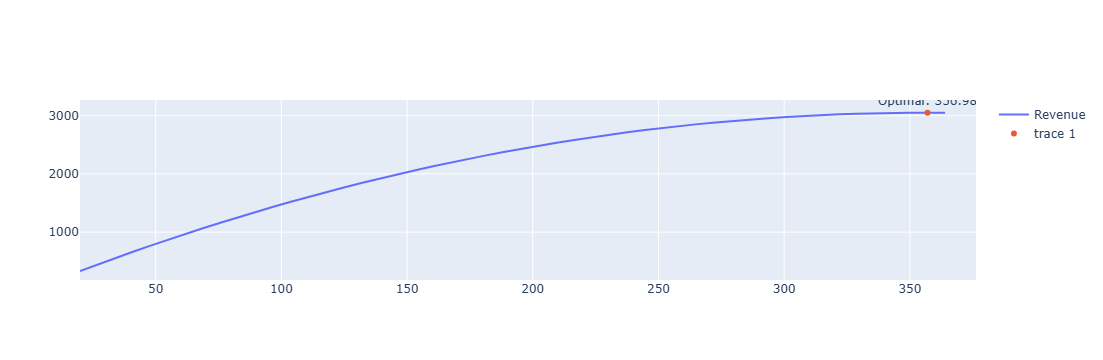

In [25]:
comp1_mean = df['comp_1'].mean()
comp2_mean = df['comp_2'].mean()
comp3_mean = df['comp_3'].mean()

price_range = np.linspace(df['unit_price'].min(), df['unit_price'].max(), 50)
revenue_list = []
for p in price_range:
    sample_df = pd.DataFrame([[p, p-comp1_mean, p-comp2_mean, p-comp3_mean, 6]], columns=feature_cols)
    sample_scaled = scaler.transform(sample_df)
    predicted_qty = lin_model.predict(sample_scaled)[0]
    revenue_list.append(p * max(predicted_qty, 0))
optimal_price = price_range[np.argmax(revenue_list)]
print('Optimal Price:', optimal_price)

fig = go.Figure()
fig.add_trace(go.Scatter(x=price_range,y=revenue_list,mode='lines',name='Revenue'))
fig.add_trace(go.Scatter(x=[optimal_price],y=[max(revenue_list)],mode='markers+text',text=[f'Optimal: {optimal_price:.2f}'],textposition='top center'))
fig.show()

In [28]:
# Save
joblib.dump(lin_model, 'pricing_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Saved")

Saved
